## SJM-BL Simulation study (scenario 1)
### 1.0 Loading packages

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

# Custom SJM package
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd

# PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from pypfopt.black_litterman import BlackLittermanModel

### 2.0 Data Simulation


In [62]:
ASSETS = ["Value", "Growth", "LowVol", "Size", "Momentum", "Quality"]
N_ASSETS = len(ASSETS)

def simulate_1state_data(num_days, seed=None):
    """
    Single-regime (1-state) Gaussian process for 6 'factor' assets.
    """
    rng = np.random.default_rng(seed)
    mu = 0.000461
    sig = 0.008388

    corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(corr, 1.0)
    cov = np.outer(np.full(N_ASSETS, sig), np.full(N_ASSETS, sig)) * corr

    rets = rng.multivariate_normal(
        mean=np.full(N_ASSETS, mu),
        cov=cov,
        size=num_days
    )
    return pd.DataFrame(rets, columns=ASSETS)

def simulate_2state_data(num_days, seed=None):
    rng = np.random.default_rng(seed)
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    mu_dict  = {0: 0.0006,   1: -0.000881}
    sig_dict = {0: 0.00757,  1: 0.0163}

    base_corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(base_corr, 1.0)

    all_states = np.zeros((num_days, N_ASSETS), dtype=int)
    for i in range(N_ASSETS):
        s = np.zeros(num_days, dtype=int)
        s[0] = rng.integers(2)
        for t in range(1, num_days):
            s[t] = rng.choice(2, p=transmat[s[t - 1]])
        all_states[:, i] = s

    rets = np.zeros((num_days, N_ASSETS))
    for t in range(num_days):
        mu_vec  = np.zeros(N_ASSETS)
        sig_vec = np.zeros(N_ASSETS)
        for i in range(N_ASSETS):
            curr_state = all_states[t, i]
            mu_vec[i]  = mu_dict[curr_state]
            sig_vec[i] = sig_dict[curr_state]
        cov_t = np.outer(sig_vec, sig_vec) * base_corr
        rets[t] = rng.multivariate_normal(mean=mu_vec, cov=cov_t)

    return pd.DataFrame(rets, columns=ASSETS), all_states

def simulate_3state_data(num_days, seed=None):
    rng = np.random.default_rng(seed)
    transmat = np.array([
        [0.9989, 0.0004, 0.0007],
        [0.0089, 0.9904, 0.0007],
        [0.0089, 0.0004, 0.9907]
    ])
    mu_list  = [0.0008, 0.0,     -0.003586]
    sig_list = [0.0070, 0.0050,  0.01897]

    base_corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(base_corr, 1.0)

    all_states = np.zeros((num_days, N_ASSETS), dtype=int)
    for i in range(N_ASSETS):
        s = np.zeros(num_days, dtype=int)
        s[0] = rng.integers(3)
        for t in range(1, num_days):
            s[t] = rng.choice(3, p=transmat[s[t - 1]])
        all_states[:, i] = s

    rets = np.zeros((num_days, N_ASSETS))
    for t in range(num_days):
        mu_vec  = np.zeros(N_ASSETS)
        sig_vec = np.zeros(N_ASSETS)
        for i in range(N_ASSETS):
            st_i   = all_states[t, i]
            mu_vec[i]  = mu_list[st_i]
            sig_vec[i] = sig_list[st_i]
        cov_t = np.outer(sig_vec, sig_vec) * base_corr
        rets[t] = rng.multivariate_normal(mean=mu_vec, cov=cov_t)

    return pd.DataFrame(rets, columns=ASSETS), all_states

### 3.0 Training Regime Models

#### 3.1 Training HMM using kmeans clustering initialization

In [63]:
def run_mle(observations, n_components=2, init_type='default', seed=None):
    model = GaussianHMM(
        n_components=n_components,
        covariance_type='diag',
        n_iter=100,
        random_state=seed
    )
    if init_type == 'default':
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_  = np.array([
            [0.9, 0.1],
            [0.1, 0.9]
        ])
        model.means_  = np.zeros((n_components, observations.shape[1]))
        model.covars_ = np.full((n_components, observations.shape[1]), 1e-10)
        model.init_params = ''
    elif init_type == 'kmeans':
        km = KMeans(n_clusters=n_components, n_init=10, random_state=seed)
        labels = km.fit_predict(observations)
        means, covars = [], []
        for i in range(n_components):
            obs_i = observations[labels == i]
            means.append(np.mean(obs_i, axis=0))
            covars.append(np.var(obs_i, axis=0) + 1e-10)
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_  = np.ones((n_components, n_components)) / n_components
        model.means_     = np.array(means)
        model.covars_    = np.array(covars)
        model.init_params = ''

    model.fit(observations)
    pred_states = model.predict(observations)
    return model, pred_states

def run_mle_default(observations, seed=None):
    return run_mle(observations, init_type='default', seed=seed)

def run_mle_kmeans(observations, seed=None):
    return run_mle(observations, init_type='kmeans', seed=seed)

def train_hmm_single_asset_default(series, n_components=2, random_state=42):
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_default(X, seed=random_state)
    return model

def train_hmm_single_asset_kmeans(series, n_components=2, random_state=42):
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_kmeans(X, seed=random_state)
    return model

#### 3.2 Training Sparse Jump model with max_feats=9 and lambda=80
##### 3.2.1 Defining feature selection framework

In [64]:
def compute_sjm_features(factor_ser: pd.Series) -> pd.DataFrame:
    def ewm_downside_dev(returns: pd.Series, halflife: float) -> pd.Series:
        negative_returns = returns.clip(upper=0)
        neg_sq = negative_returns ** 2
        ewm_mean = neg_sq.ewm(halflife=halflife, adjust=False).mean()
        return np.sqrt(ewm_mean)

    dd20 = ewm_downside_dev(factor_ser, halflife=20)
    dd60 = ewm_downside_dev(factor_ser, halflife=60)
    dd120 = ewm_downside_dev(factor_ser, halflife=120)

    feat_dd20 = dd20
    feat_dd20_minus_dd60 = dd20 - dd60
    feat_dd60_minus_dd120 = dd60 - dd120
    ret_hl120 = factor_ser.ewm(halflife=120, adjust=False).mean()

    feats = {
        "DD_hl20": feat_dd20,
        "DD20_minus_DD60": feat_dd20_minus_dd60,
        "DD60_minus_DD120": feat_dd60_minus_dd120,
        "Return_hl120": ret_hl120,
    }
    df_feats = pd.DataFrame(feats)
    df_feats = df_feats.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return df_feats

def train_sjm_single_asset(series, n_components=2, max_feats=4, lam=50, random_state=42):
    feats_df = compute_sjm_features(series)
    feats_df = feats_df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScalerPD()

    X_clipped = clipper.fit_transform(feats_df)
    X_scaled  = scaler.fit_transform(X_clipped)
    X_arr = X_scaled.values

    sjm = SparseJumpModel(
        n_components=n_components,
        max_feats=max_feats,
        jump_penalty=lam,
        cont=False,
        max_iter=20,
        random_state=random_state
    )
    sjm.fit(X_arr)

    return sjm, clipper, scaler

### 3.0 Helper Functions

In [65]:
def get_rolling_cov(full_returns, current_index, halflife=126):
    """
    Returns an exponentially weighted covariance using data up to `current_index`.
    """
    sub_df = full_returns.iloc[:current_index]
    if len(sub_df) < 2:
        n_ = sub_df.shape[1]
        return np.eye(n_)
    # Convert half-life -> span
    span_equiv = (2 / (1 - np.exp(-np.log(2)/halflife))) - 1
    cov_est = risk_models.exp_cov(sub_df, span=span_equiv, returns_data=True)
    return cov_est

def backtest_portfolio(returns, weights, transaction_cost=0.0007):
    """
    Static backtest for illustration only (no rebalancing in-between).
    """
    T = len(returns)
    pv = np.zeros(T)
    pv[0] = 1.0 - (np.sum(np.abs(weights)) * transaction_cost)  # initial cost
    for t in range(T - 1):
        ret_t = returns.iloc[t].values
        pv[t + 1] = pv[t] * (1.0 + np.dot(weights, ret_t))
    return pv



In [66]:
#Compute performance metrics for evaluation


def compute_performance_metrics(portfolio_vals, weight_history=None, annual_factor=250):
    pv = np.asarray(portfolio_vals)
    rets = np.diff(pv) / pv[:-1]
    ann_ret = rets.mean() * annual_factor
    cum_ret = pv[-1] / pv[0] - 1
    ann_vol = rets.std() * np.sqrt(annual_factor)
    neg_rets = rets[rets < 0]
    ddev = neg_rets.std() * np.sqrt(annual_factor) if len(neg_rets) > 0 else 0.0
    max_dd = (pv / np.maximum.accumulate(pv) - 1).min()

    sharpe  = ann_ret / (ann_vol + 1e-12)
    sortino = ann_ret / ddev if ddev > 1e-12 else np.nan
    calmar  = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    if weight_history is not None and len(weight_history) > 1:
        turnovers = [
            np.sum(np.abs(weight_history[t] - weight_history[t - 1]))
            for t in range(1, len(weight_history))
        ]
        avg_turnover = np.mean(turnovers)
    else:
        avg_turnover = 0.0

    return {
        "Annualized Return": ann_ret,
        "Cumulative Return": cum_ret,
        "Volatility": ann_vol,
        "Downside Deviation": ddev,
        "Max Drawdown": max_dd,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Calmar Ratio": calmar,
        "Turnover Rate": avg_turnover,
    }

### 4.0




In [67]:
def compute_performance_metrics(portfolio_vals, weight_history=None, annual_factor=250):
    """
    Compute return, risk, and risk-adjusted performance measures from a
    time series of portfolio values.
    """
    pv = np.asarray(portfolio_vals)
    rets = np.diff(pv) / pv[:-1]

    ann_ret = rets.mean() * annual_factor
    cum_ret = pv[-1] / pv[0] - 1
    ann_vol = rets.std() * np.sqrt(annual_factor)

    negative_rets = rets[rets < 0]
    ddev = negative_rets.std() * np.sqrt(annual_factor) if len(negative_rets) > 0 else 0.0
    max_dd = (pv / np.maximum.accumulate(pv) - 1).min()

    sharpe = ann_ret / (ann_vol + 1e-12)
    sortino = ann_ret / ddev if ddev > 1e-12 else np.nan
    calmar = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    if weight_history is not None and len(weight_history) > 1:
        turnover_list = []
        for t in range(1, len(weight_history)):
            turnover_list.append(np.sum(np.abs(weight_history[t] - weight_history[t - 1])))
        avg_turnover = np.mean(turnover_list)
    else:
        avg_turnover = 0.0

    return {
        "Annualized Return": ann_ret,
        "Cumulative Return": cum_ret,
        "Volatility": ann_vol,
        "Downside Deviation": ddev,
        "Max Drawdown": max_dd,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Calmar Ratio": calmar,
        "Turnover Rate": avg_turnover,
    }

#### 5.1 Regime based allocation

In [68]:
def regime_based_bl_backtest(
    df_train,
    df_test,
    states_test,
    regime_means_list,
    init_state,
    risk_free_rate=0.02/252,
    transaction_cost=0.0007,
    bl_tau=0.05,
    halflife=126
):
    """
    On day t:
      - We *first* apply the old weights to day t-1 returns,
        so portfolio grows from day t-1 to t.
      - Then check if we rebalance at the END of day t, 
        using states_test[t-1] to determine our new weights. 
        (One-day delay logic)
    Fallback if a regime wasn't seen in training => return=0.0,
    fallback for EF => equal weights if max_sharpe fails.
    Rolling cov estimated daily from [0..(train+ t)] with exp decay.
    risk_aversion=2.5 is set in the BL model.
    """
    T_test = len(df_test)
    assets = df_test.columns
    n_assets = len(assets)

    # Combine for rolling
    combined_df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
    portfolio_vals = np.zeros(T_test)
    portfolio_vals[0] = 1.0
    weight_history = np.zeros((T_test, n_assets))
    # Start with equal weights
    w_prev = np.ones(n_assets) / n_assets
    weight_history[0] = w_prev

    fallback_records = []

    for t in range(1, T_test):
        # Apply old weights to day t-1 returns
        ret_t_minus_1 = df_test.iloc[t - 1].values
        gross_growth = portfolio_vals[t - 1] * (1.0 + np.dot(w_prev, ret_t_minus_1))

        # Decide if we do a rebalance at the end of day t
        # For t==1, we must do an initial rebalance.
        if t == 1:
            current_states = init_state
            do_rebalance = True
        else:
            # Use states_test[t-1] vs states_test[t-2] 
            # If ANY asset changes from day to day => rebalance
            current_states = states_test[t - 1]
            prev_states    = states_test[t - 2]
            do_rebalance = not np.all(current_states == prev_states)

        if do_rebalance:
            # Build absolute views = regime_means_list[i][state_i], fallback=0.0
            view_vector = []
            for i in range(n_assets):
                st_i = current_states[i]
                # If st_i not in training => 0.0
                view_vector.append(regime_means_list[i].get(st_i, 0.0))

            # Rolling covariance up to global index (train_size + t)
            global_index = len(df_train) + t
            cov_t = get_rolling_cov(combined_df, global_index, halflife=halflife)

            # BL with risk_aversion=2.5
            bl = BlackLittermanModel(
                cov_matrix=cov_t,
                pi="equal",  # "equal" prior means
                absolute_views=dict(zip(assets, view_vector)),
                tau=bl_tau,
                risk_aversion=2.5
            )
            posterior_rets = bl.bl_returns()

            ef = EfficientFrontier(posterior_rets, cov_t, weight_bounds=(0, 1), solver="SCS")
            try:
                w_dict = ef.max_sharpe(risk_free_rate=risk_free_rate)
            except ValueError:
                # fallback => equal weights
                w_dict = {a: 1.0 / n_assets for a in assets}
                fallback_records.append({
                    "t": t,
                    "states": current_states,
                    "reason": "max_sharpe fail => eq weights"
                })
            w_array = np.array([w_dict[a] for a in assets])
        else:
            w_array = w_prev.copy()

        # Transaction cost
        traded_fraction = np.sum(np.abs(w_array - w_prev))
        cost = gross_growth * traded_fraction * transaction_cost
        portfolio_vals[t] = gross_growth - cost

        # Update weight
        weight_history[t] = w_array
        w_prev = w_array

    return portfolio_vals, weight_history, fallback_records

#### 6.0 Wrapper to run scenarios

In [69]:
def get_regime_means_stds_single_asset(asset_series, regime_assignments):
    """
    Return {regime -> mean_return} for each observed regime.
    """
    unique_states = np.unique(regime_assignments)
    regime_means = {}
    for s in unique_states:
        data_in_s = asset_series[regime_assignments == s]
        if len(data_in_s) > 0:
            regime_means[s] = data_in_s.mean()
        else:
            regime_means[s] = 0.0
    return regime_means

def equal_weight_allocation(n):
    return np.ones(n) / n

def inverse_vol_weights(df):
    stds = df.std(axis=0).values + 1e-12
    w = 1.0 / stds
    return w / w.sum()

def static_mvo_allocation(df, risk_free_rate=0.02/252):
    # Simple MVO on sample mean & sample cov
    mu = expected_returns.mean_historical_return(df, frequency=250)
    cov = risk_models.sample_cov(df)
    try:
        ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1), solver="SCS")
        w_dict = ef.max_sharpe(risk_free_rate=risk_free_rate)
    except Exception as e:
        print("max_sharpe failed:", e)
        # Create a new instance to call min_volatility
        ef_alt = EfficientFrontier(mu, cov, weight_bounds=(0, 1), solver="SCS")
        w_dict = ef_alt.min_volatility()
    return w_dict


def run_allocation(df, lam_sjm=50, scenario_name=""):
    """
    Splits df 80/20. Trains HMM & SJM. Then runs:
      1) EW
      2) Inverse Vol
      3) Static MVO
      4) HMM-BL-Default
      5) HMM-BL-KMeans
      6) SJM-BL
      with the updated (rolling-cov, fallback=eq-weights, 1-day delay, etc.)
    """
    split_idx = int(len(df)*0.8)
    df_train = df.iloc[:split_idx]
    df_test  = df.iloc[split_idx:]

    # Train models per asset
    hmm_models_default = []
    hmm_models_kmeans  = []
    sjm_models         = []
    sjm_clippers       = []
    sjm_scalers        = []

    hmm_states_default_train = np.zeros((split_idx, N_ASSETS), dtype=int)
    hmm_states_kmeans_train  = np.zeros((split_idx, N_ASSETS), dtype=int)
    sjm_states_train         = np.zeros((split_idx, N_ASSETS), dtype=int)

    for i, asset in enumerate(ASSETS):
        series_train = df_train[asset]

        # HMM default
        hmm_d = train_hmm_single_asset_default(series_train)
        st_def = hmm_d.predict(series_train.values.reshape(-1, 1))
        hmm_models_default.append(hmm_d)
        hmm_states_default_train[:, i] = st_def

        # HMM kmeans
        hmm_k = train_hmm_single_asset_kmeans(series_train)
        st_km = hmm_k.predict(series_train.values.reshape(-1, 1))
        hmm_models_kmeans.append(hmm_k)
        hmm_states_kmeans_train[:, i] = st_km

        # SJM
        sjm_mod, clipper, scaler = train_sjm_single_asset(series_train, lam=lam_sjm)
        feats_train = compute_sjm_features(series_train).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        X_tr_clip = clipper.transform(feats_train)
        X_tr_scl  = scaler.transform(X_tr_clip)
        st_sjm = sjm_mod.predict(X_tr_scl.values)

        sjm_models.append(sjm_mod)
        sjm_clippers.append(clipper)
        sjm_scalers.append(scaler)
        sjm_states_train[:, i] = st_sjm

    # In-sample means
    hmm_regime_means_default = []
    hmm_regime_means_kmeans  = []
    sjm_regime_means         = []

    for i in range(N_ASSETS):
        asset_train = df_train.iloc[:, i]
        # HMM default
        m_def = get_regime_means_stds_single_asset(asset_train, hmm_states_default_train[:, i])
        hmm_regime_means_default.append(m_def)
        # HMM kmeans
        m_km = get_regime_means_stds_single_asset(asset_train, hmm_states_kmeans_train[:, i])
        hmm_regime_means_kmeans.append(m_km)
        # SJM
        m_sjm = get_regime_means_stds_single_asset(asset_train, sjm_states_train[:, i])
        sjm_regime_means.append(m_sjm)

    # Predict states daily in test
    T_test = len(df_test)
    hmm_states_default_test = np.zeros((T_test, N_ASSETS), dtype=int)
    hmm_states_kmeans_test  = np.zeros((T_test, N_ASSETS), dtype=int)
    sjm_states_test         = np.zeros((T_test, N_ASSETS), dtype=int)

    full_data = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
    for i, asset in enumerate(ASSETS):
        asset_full = full_data[asset].values

        # HMM default
        for t in range(T_test):
            end_idx = split_idx + t + 1
            partial_data = asset_full[:end_idx].reshape(-1, 1)
            partial_states = hmm_models_default[i].predict(partial_data)
            hmm_states_default_test[t, i] = partial_states[-1]

        # HMM kmeans
        for t in range(T_test):
            end_idx = split_idx + t + 1
            partial_data = asset_full[:end_idx].reshape(-1, 1)
            partial_states = hmm_models_kmeans[i].predict(partial_data)
            hmm_states_kmeans_test[t, i] = partial_states[-1]

        # SJM
        feats_full = compute_sjm_features(pd.Series(asset_full))
        feats_full = feats_full.replace([np.inf, -np.inf], np.nan).fillna(0.0)
        X_full_clip = sjm_clippers[i].transform(feats_full)
        X_full_scl  = sjm_scalers[i].transform(X_full_clip)
        for t in range(T_test):
            end_idx = split_idx + t + 1
            partial_X = X_full_scl[:end_idx]
            partial_states = sjm_models[i].predict(partial_X)
            sjm_states_test[t, i] = partial_states.iloc[-1]

    # === STRATEGIES ===
    # 1) Equal Weight
    w_ew = equal_weight_allocation(N_ASSETS)
    pv_ew = backtest_portfolio(df_test, w_ew, transaction_cost=0.0007)
    w_hist_ew = np.tile(w_ew, (T_test, 1))

    # 2) Inverse Vol
    w_iv = inverse_vol_weights(df_test)
    pv_iv = backtest_portfolio(df_test, w_iv, transaction_cost=0.0007)
    w_hist_iv = np.tile(w_iv, (T_test, 1))

    # 3) Static MVO
    w_mvo_dict = static_mvo_allocation(df_train)
    w_mvo_arr = np.array([w_mvo_dict[a] for a in df_train.columns])
    pv_mvo = backtest_portfolio(df_test, w_mvo_arr, transaction_cost=0.0007)
    w_hist_mvo = np.tile(w_mvo_arr, (T_test, 1))

    # 4) HMM-BL-Default
    pv_hmmbl_def, w_hmmbl_def, fb_def = regime_based_bl_backtest(
        df_train, df_test,
        hmm_states_default_test,
        hmm_regime_means_default,
        hmm_states_default_train[-1],  # init state
        transaction_cost=0.0007,
        risk_free_rate=0.02/252,
        bl_tau=0.05,
        halflife=126
    )

    # 5) HMM-BL-KMeans
    pv_hmmbl_km, w_hmmbl_km, fb_km = regime_based_bl_backtest(
        df_train, df_test,
        hmm_states_kmeans_test,
        hmm_regime_means_kmeans,
        hmm_states_kmeans_train[-1],
        transaction_cost=0.0007,
        risk_free_rate=0.02/252,
        bl_tau=0.05,
        halflife=126
    )

    # 6) SJM-BL
    pv_sjmbl, w_sjmbl, fb_sjm = regime_based_bl_backtest(
        df_train, df_test,
        sjm_states_test,
        sjm_regime_means,
        sjm_states_train[-1],
        transaction_cost=0.0007,
        risk_free_rate=0.02/252,
        bl_tau=0.05,
        halflife=126
    )

    perf = {
        "EW": compute_performance_metrics(pv_ew, w_hist_ew),
        "IV": compute_performance_metrics(pv_iv, w_hist_iv),
        "MVO": compute_performance_metrics(pv_mvo, w_hist_mvo),
        "HMM-BL-Default": compute_performance_metrics(pv_hmmbl_def, w_hmmbl_def),
        "HMM-BL-KMeans":  compute_performance_metrics(pv_hmmbl_km, w_hmmbl_km),
        "SJM-BL":         compute_performance_metrics(pv_sjmbl, w_sjmbl),
    }

    # store time-series for plotting
    pvs = {
        "EW": pv_ew,
        "IV": pv_iv,
        "MVO": pv_mvo,
        "HMM-BL-Default": pv_hmmbl_def,
        "HMM-BL-KMeans": pv_hmmbl_km,
        "SJM-BL": pv_sjmbl
    }
    weights = {
        "EW": w_hist_ew,
        "IV": w_hist_iv,
        "MVO": w_hist_mvo,
        "HMM-BL-Default": w_hmmbl_def,
        "HMM-BL-KMeans": w_hmmbl_km,
        "SJM-BL": w_sjmbl
    }
    fallback_events = {
        "HMM-BL-Default": fb_def,
        "HMM-BL-KMeans": fb_km,
        "SJM-BL": fb_sjm
    }

    return perf, pvs, weights, fallback_events

In [70]:
def run_scenario_123(T_sim=1000, lam_sjm=50):
    # 1-state
    df1_full = simulate_1state_data(T_sim, seed=100)
    perf_1, pvs_1, w_1, fb_1 = run_allocation(df1_full, lam_sjm=lam_sjm, scenario_name="1-state")

    # 2-state
    df2_full, _ = simulate_2state_data(T_sim, seed=200)
    perf_2, pvs_2, w_2, fb_2 = run_allocation(df2_full, lam_sjm=lam_sjm, scenario_name="2-state")

    # 3-state
    df3_full, _ = simulate_3state_data(T_sim, seed=300)
    perf_3, pvs_3, w_3, fb_3 = run_allocation(df3_full, lam_sjm=lam_sjm, scenario_name="3-state")

    return {
        "1state": {"perf": perf_1, "pvs": pvs_1, "weights": w_1, "fallbacks": fb_1},
        "2state": {"perf": perf_2, "pvs": pvs_2, "weights": w_2, "fallbacks": fb_2},
        "3state": {"perf": perf_3, "pvs": pvs_3, "weights": w_3, "fallbacks": fb_3},
    }

### 7.0 Main execution: Run simulation and output performance metrics

In [ ]:
if __name__ == "__main__":
    results = run_scenario_123(T_sim=5000, lam_sjm=100)
    
    # Performance metrics (using the keys returned by run_scenario_123)
    perf_1 = results["1state"]["perf"]
    perf_2 = results["2state"]["perf"]
    perf_3 = results["3state"]["perf"]

    # Print performance metrics for a sanity check
    print("1-State Performance:\n", pd.DataFrame(perf_1).T)
    print("2-State Performance:\n", pd.DataFrame(perf_2).T)
    print("3-State Performance:\n", pd.DataFrame(perf_3).T)

Model is not converging.  Current: 13401.876855571816 is not greater than 13401.877988222122. Delta is -0.0011326503063173732
Model is not converging.  Current: 13485.129316976065 is not greater than 13485.140926957556. Delta is -0.011609981491346844
Model is not converging.  Current: 13491.222431315613 is not greater than 13491.235089160646. Delta is -0.012657845032663317
Model is not converging.  Current: 13441.546252824812 is not greater than 13441.561793663855. Delta is -0.015540839043751475


### 8.0 Visualizations

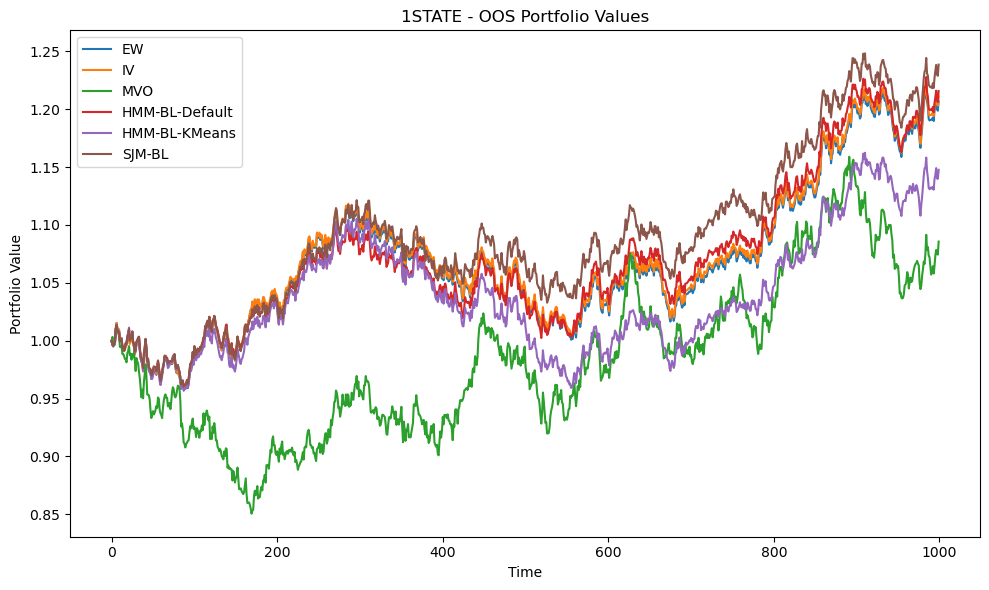

In [ ]:
    # Example plot for the 1-state scenario
    scenario_key = "1state"
    pvs_1 = results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_1.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

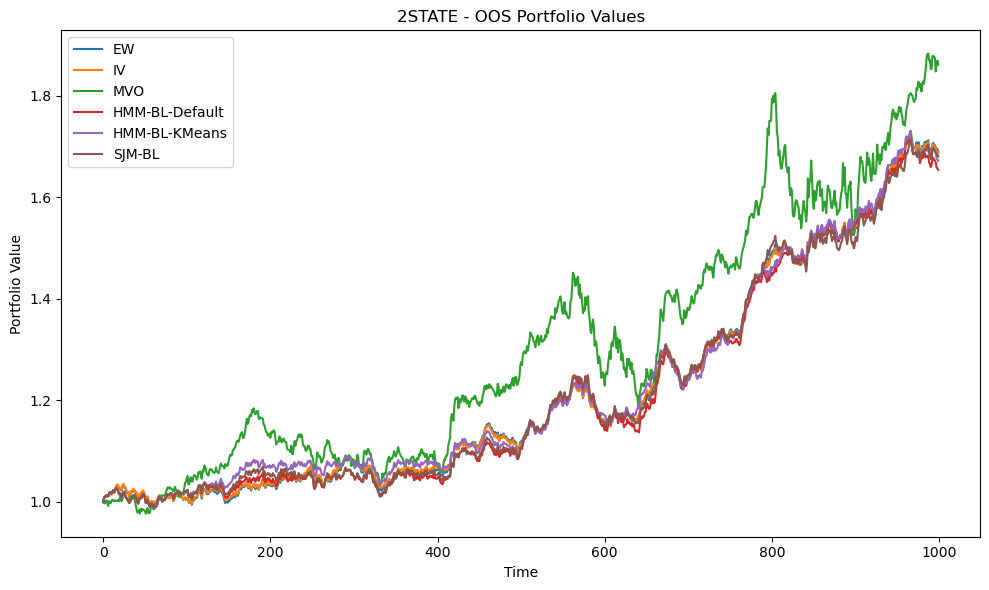

In [ ]:
    # Example plot for the 2-state scenario
    scenario_key = "2state"
    pvs_2 = results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_2.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

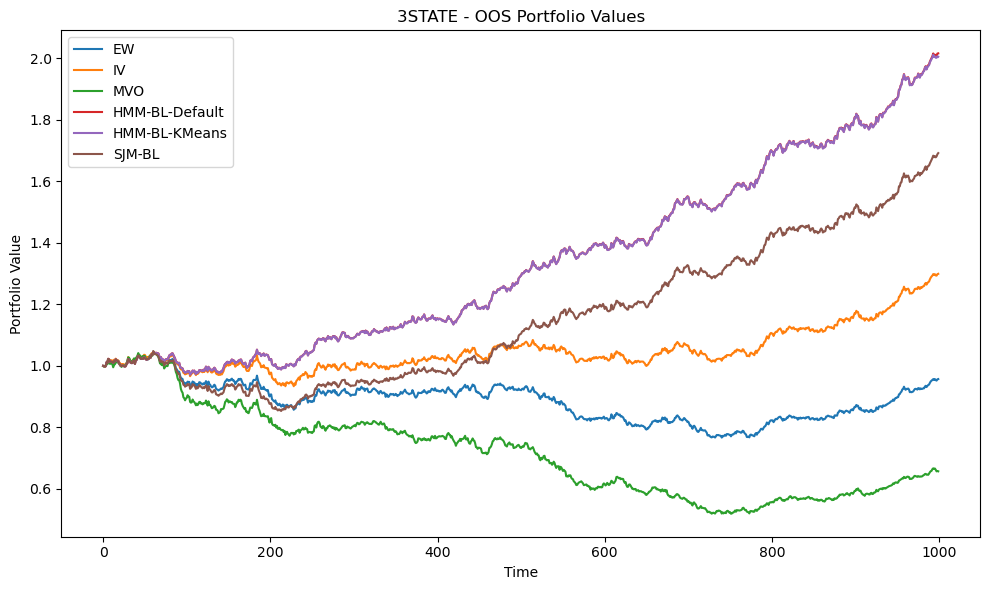

In [ ]:
    # Example plot for the 3-state scenario
    scenario_key = "3state"
    pvs_3 = results[scenario_key]["pvs"]
    plt.figure(figsize=(10, 6))
    for strat, vals in pvs_3.items():
        plt.plot(vals, label=strat)
    plt.title(f"{scenario_key.upper()} - OOS Portfolio Values")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


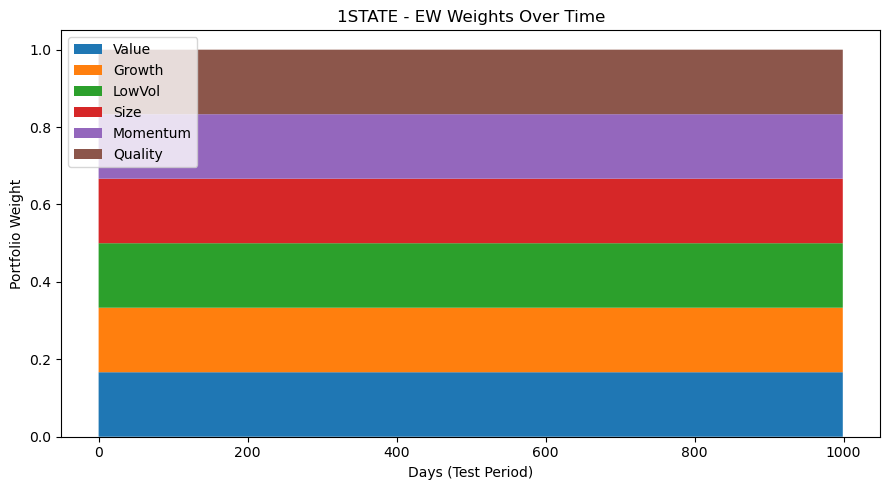

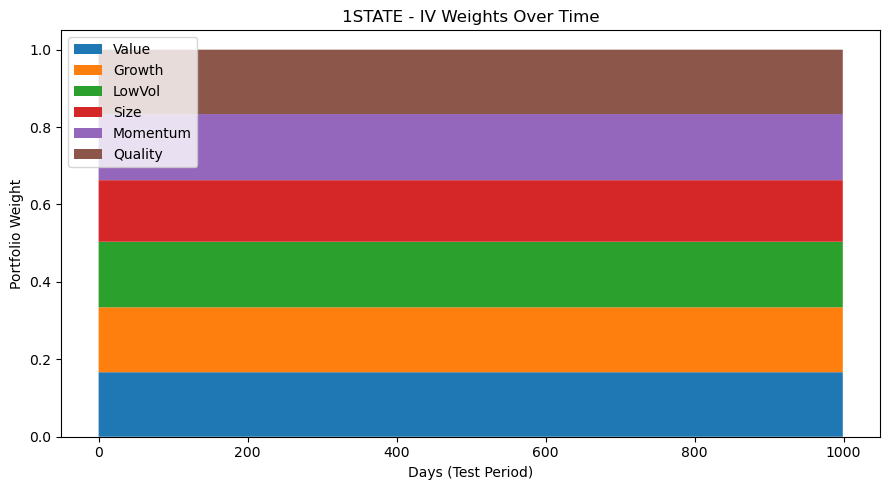

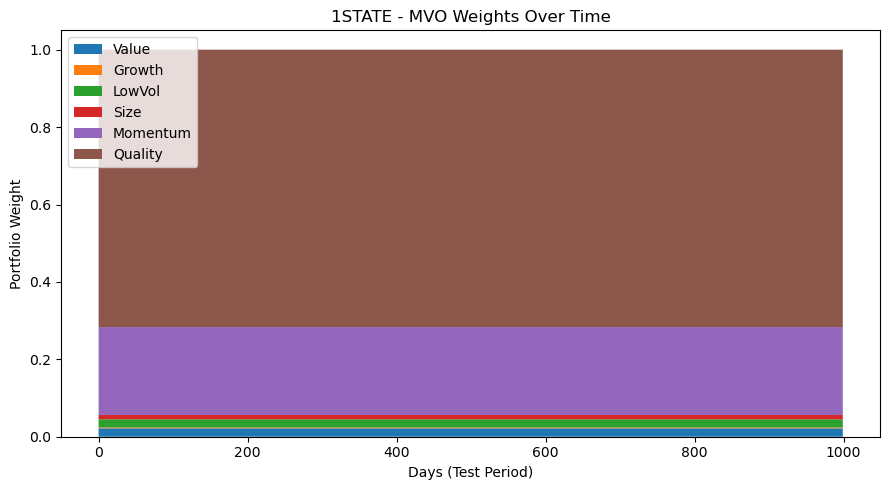

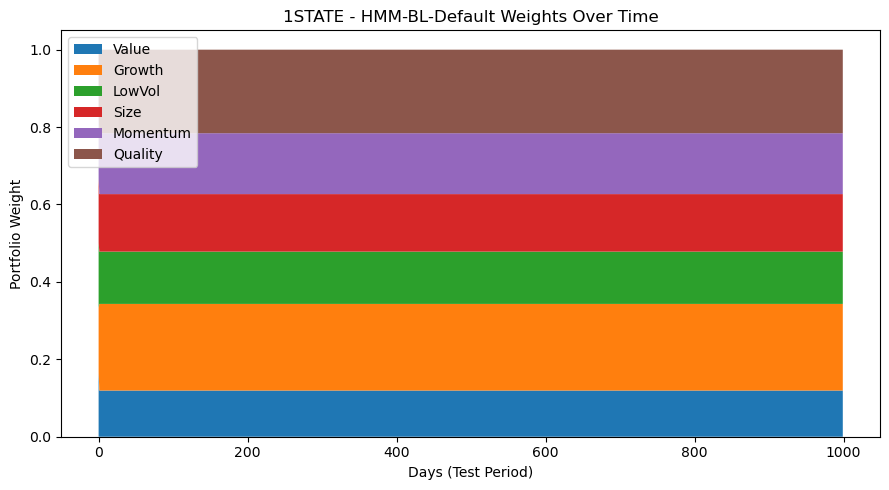

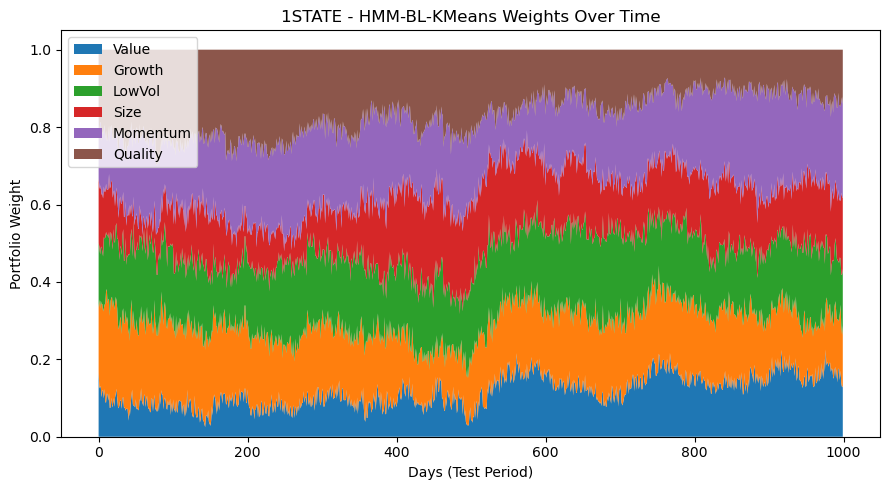

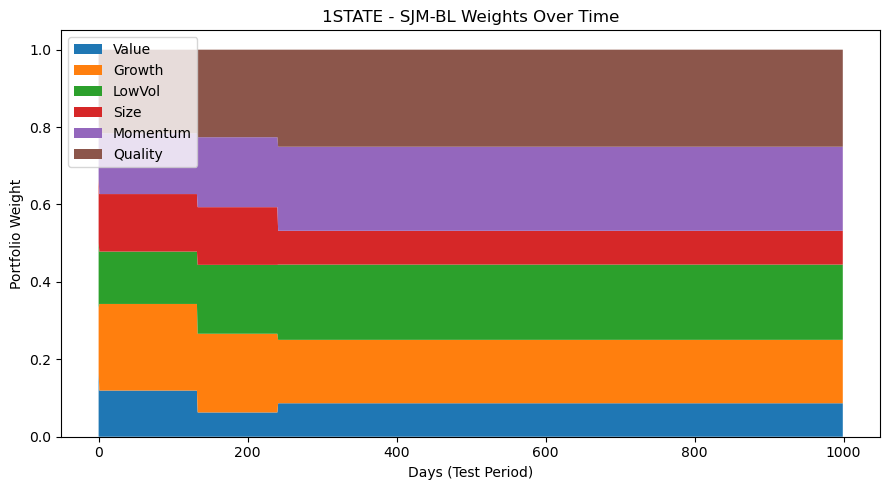

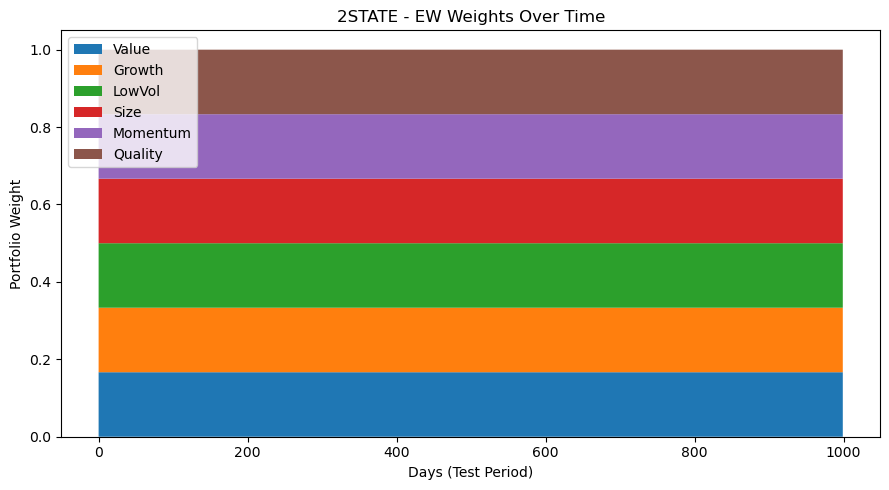

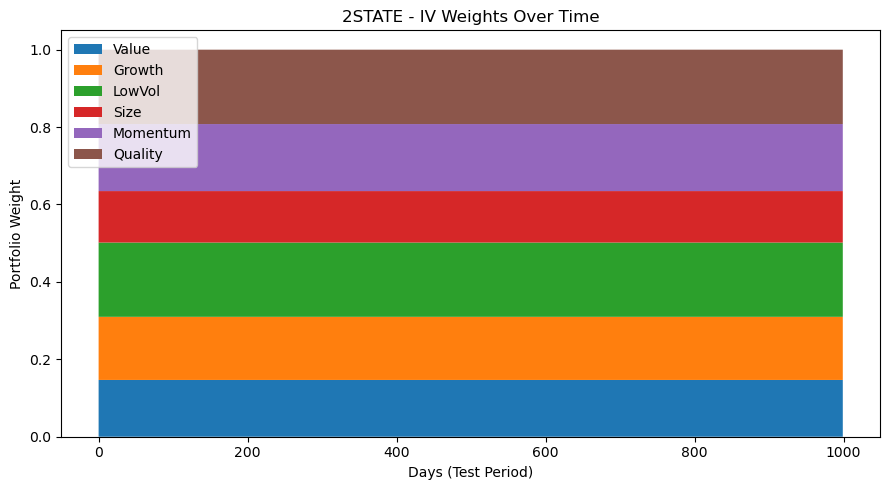

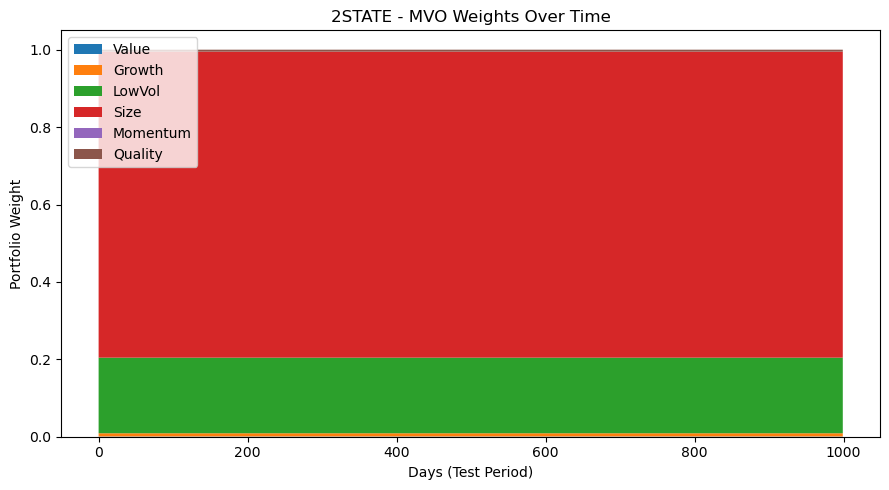

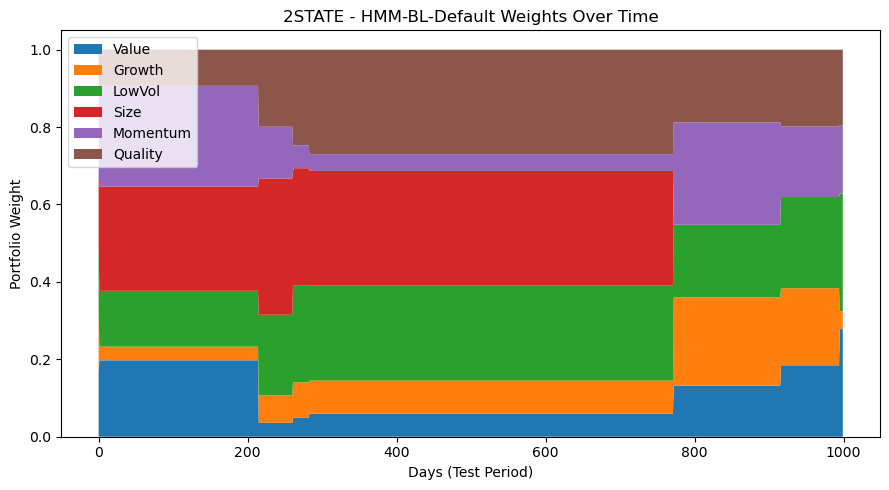

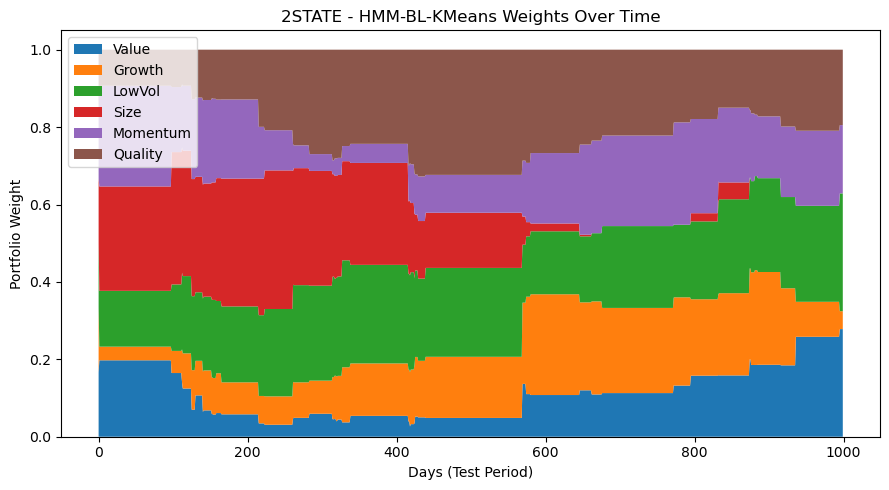

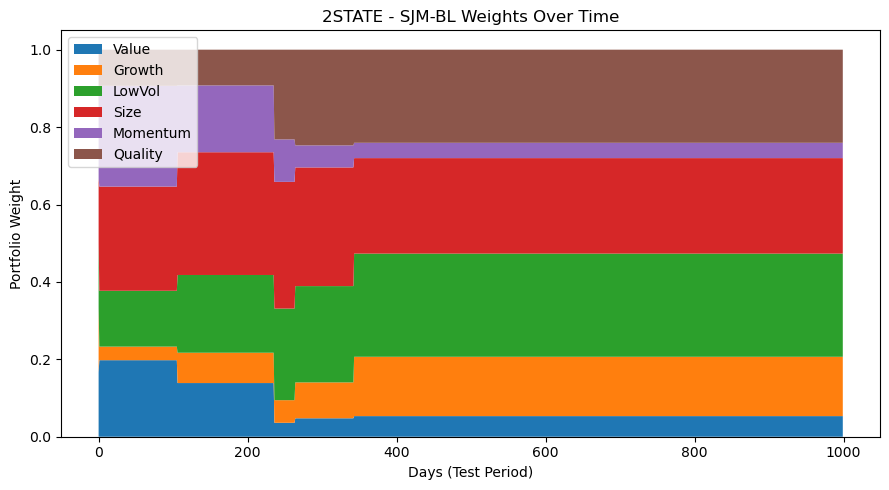

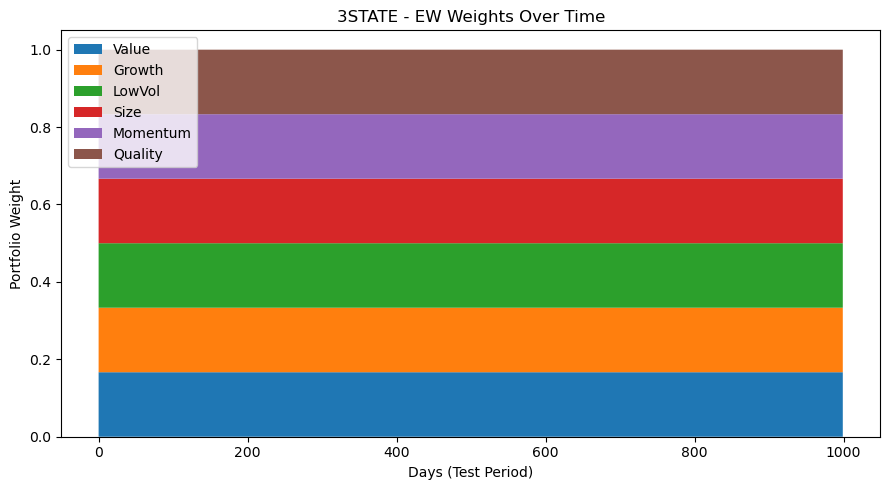

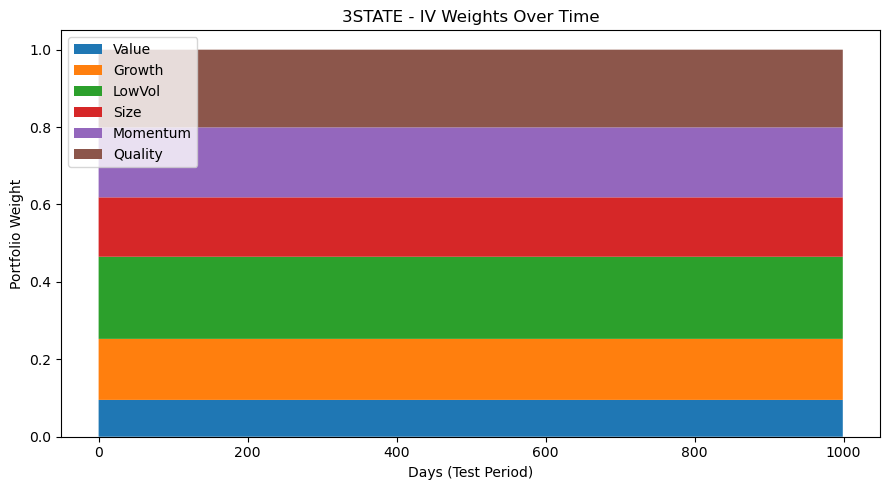

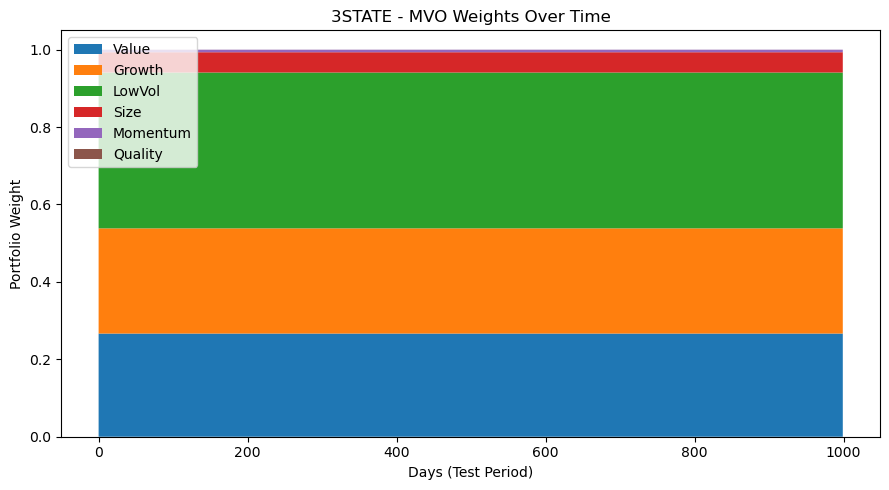

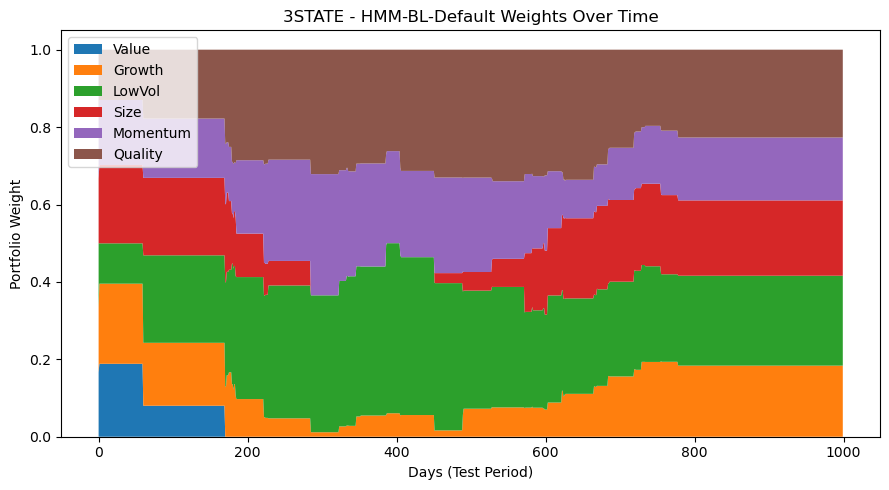

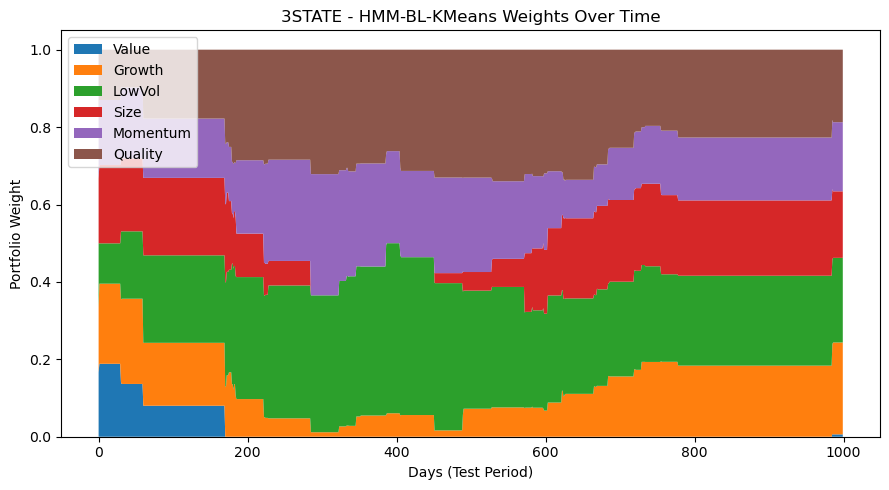

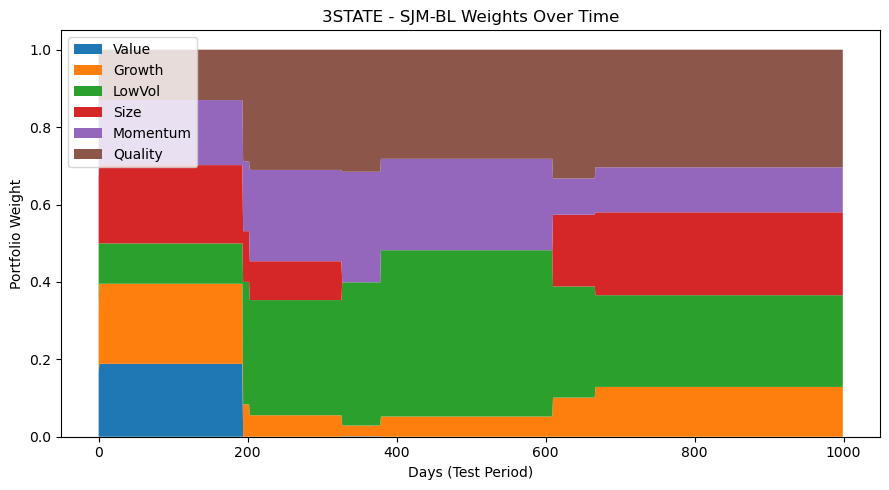

In [ ]:
    # Plotting weight histories for each scenario and strategy
    scenarios = ["1state", "2state", "3state"]
    for scenario in scenarios:
        # Get the weight history dictionary for the current scenario
        weights_dict = results[scenario]["weights"]
        # Get the test period length from one of the weight arrays (assumes all have same length)
        T_test = next(iter(weights_dict.values())).shape[0]
        for strategy, w_hist in weights_dict.items():
            plt.figure(figsize=(9, 5))
            x_vals = np.arange(T_test)
            plt.stackplot(x_vals, *w_hist.T, labels=ASSETS)
            plt.title(f"{scenario.upper()} - {strategy} Weights Over Time")
            plt.xlabel("Days (Test Period)")
            plt.ylabel("Portfolio Weight")
            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.show()